<strong> Football Data import using free API from football_data.org </strong>
<br>
<br>
[(https://rapidapi.com/Creativesdev/api/free-api-live-football-data/playground/apiendpoint_4c79d258-7ac0-4e0d-90e1-aa7f76cf1dd9)]
<br>
<br>
max calls 100 per day, import all data

<strong><span style="color:Red"> imports

In [1]:
print("importing libraries")
from datetime import datetime
print(f"start time {datetime.now()}")
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import urllib
import matplotlib.pyplot as plt
import pytz
print("imports complete")

importing libraries
start time 2024-12-29 19:04:53.791789
imports complete


<strong><span style="color:green"> keys and connections

write API results to SQL DB

In [2]:
# #database connection detials
# server = r"LAPTOP-ODMD499J\ZWDEV001"
# database = "football_analysis"

# connection_string = (
#     f'mssql+pyodbc:///?odbc_connect="
#     + urllib.parse.quote_plus(
#         f"Driver={{ODBC Driver 17 for SQL Server}};"
#         f"Server={server};"
#         f"Database={database};"
#         f"Trusted_Connection=yes;"
#     )
# )

# # Create SQLAlchemy engine
# engine = create_engine(connection_string)

# conn=create_engine


In [3]:
#free rapid API
api_key = 'a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4'

In [4]:
# conn = http.client.HTTPSConnection("free-api-live-football-data.p.rapidapi.com")

# headers = {
#     'x-rapidapi-key': "a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4",
#     'x-rapidapi-host': "free-api-live-football-data.p.rapidapi.com"
# }

# conn.request("GET", "/football-popular-leagues", headers=headers)

# res = conn.getresponse()
# data = res.read()

# # Decode the byte data to a string and load it as JSON
# data_str = data.decode("utf-8")
# response_json = json.loads(data_str)

# # Extract the relevant part of the data for the DataFrame
# popular_leagues = response_json.get("response", [])

# # Convert the JSON data to a DataFrame
# df_popular_leagues = pd.json_normalize(popular_leagues)
# df_popular_leagues = pd.json_normalize(popular_leagues, 'popular')
# # Display the DataFrame
# print(df_popular_leagues)

# df_popular_leagues.to_sql('leagues',con=engine,index=False,if_exists='replace')


In [5]:
# conn = http.client.HTTPSConnection("free-api-live-football-data.p.rapidapi.com")

# headers = {
#     'x-rapidapi-key': "a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4",
#     'x-rapidapi-host': "free-api-live-football-data.p.rapidapi.com"
# }

# conn.request("GET", "/football-get-list-all-team?leagueid=47", headers=headers)

# res = conn.getresponse()
# data = res.read()

# # Decode the byte data to a string and load it as JSON
# data_str = data.decode("utf-8")
# response_json = json.loads(data_str)

# # Extract the relevant part of the data for the DataFrame
# teams_list = response_json.get("response", {}).get("list", [])

# # Normalize and flatten the list of dictionaries
# df_teams = pd.json_normalize(teams_list)

# # Display the flattened DataFrame
# print(df_teams)

# df_teams.to_sql('teams',con=engine,index=False,if_exists='replace')



In [6]:
# conn = http.client.HTTPSConnection("free-api-live-football-data.p.rapidapi.com")

# headers = {
#     'x-rapidapi-key': "a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4",
#     'x-rapidapi-host': "free-api-live-football-data.p.rapidapi.com"
# }

# conn.request("GET", "/football-get-all-matches-by-league?leagueid=47", headers=headers)

# res = conn.getresponse()
# data = res.read()
# print(data.decode("utf-8"))
# # Decode the byte data to a string and load it as JSON
# data_str = data.decode("utf-8")
# response_json = json.loads(data_str)

# # Extract the relevant part of the data for the DataFrame
# # fixture = response_json.get("response", {}).get("matches", [])

# # Normalize and flatten the list of dictionaries
# df_fixtures = pd.json_normalize(fixture)

# # Display the flattened DataFrame
# print(df_fixtures)

# df_fixtures.to_sql('fixtures',con=engine,index=False,if_exists='replace')



In [7]:
# conn = http.client.HTTPSConnection("free-api-live-football-data.p.rapidapi.com")

# headers = {
#     'x-rapidapi-key': "a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4",
#     'x-rapidapi-host': "free-api-live-football-data.p.rapidapi.com"
# }

# #for id in df_fixtures:
# conn.request("GET", f"/football-get-match-all-stats?eventid=4506263", headers=headers)
# res = conn.getresponse()
# data = res.read()
# print(data.decode("utf-8"))
# # Decode the byte data to a string and load it as JSON
# data_str = data.decode("utf-8")
# response_json = json.loads(data_str)
# # Extract the relevant part of the data for the DataFrame
# event_detail = response_json.get("response", {}).get("stats", [])
# # Normalize and flatten the list of dictionaries
# df_event_detail = pd.json_normalize(event_detail)
# # Display the flattened DataFrame

# # Sample JSON response (replace this with your actual data)
# data_str = data.decode("utf-8")
# response_json = json.loads(data_str)

# # Step 1: Extract the data into a structured list
# stats_list = []
# for stat_group in response_json.get("response", {}).get("stats", []):
#     for stat in stat_group.get("stats", []):
#         stats_list.append({
#             "stat_title": stat.get("title"),
#             "home_stat": stat.get("stats", [None, None])[0],  # First element for home stat
#             "away_stat": stat.get("stats", [None, None])[1]   # Second element for away stat
#         })
# # Create the DataFrame
# df_event_detail = pd.DataFrame(stats_list)

# # Step 1: Pivot the DataFrame to create separate columns for home and away stats
# df_event_detail_pivoted = df_event_detail.set_index('stat_title').T

# # Step 2: Rename columns to reflect 'home' or 'away' by concatenating stat_title with home/away
# df_event_detail_pivoted.columns = [
#     f"{stat_title}_{'home' if col == 'home_stat' else 'away'}"
#     for stat_title, col in zip(df_event_detail['stat_title'], ['home_stat', 'away_stat'])
# ]

# # Step 3: Transpose to get everything in one row (if required)
# df_event_statistics_detail = df_event_detail_pivoted.transpose().T

# # Display the resulting DataFrame
# print(df_event_statistics_detail)

# df_event_statistics_detail.to_sql('event_statistics_detail',con=engine,index=False,if_exists='replace')

In [8]:
# conn = http.client.HTTPSConnection("free-api-live-football-data.p.rapidapi.com")

# headers = {
#     'x-rapidapi-key': "a8719fb165msh8145cfdce01b247p1b425ejsna232a4ee67a4",
#     'x-rapidapi-host': "free-api-live-football-data.p.rapidapi.com"
# }

# conn.request("GET", "/football-get-match-all-stats?eventid=4621624", headers=headers)

# res = conn.getresponse()
# data = res.read()

# print(data.decode("utf-8"))

git hub game week (GW) combined data pull and combination of seasons

In [9]:
print("collecting 2022-23 data")

url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df_2022_23_gw_data = pd.read_csv(url,on_bad_lines='warn')

print("collecting 2023-24 data")

url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df_2023_24_gw_data = pd.read_csv(url,on_bad_lines='warn')
#print(df_2023_24_gw_data)

print("collecting 2024-25 data")

url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df_2024_25_gw_data = pd.read_csv(url,on_bad_lines='warn')
#print(df_2024_25_gw_data)

df_2022_23_gw_data['game_year'] = '2022-23'
print(df_2022_23_gw_data.columns)

df_2023_24_gw_data['game_year'] = '2023-24'
print(df_2023_24_gw_data.columns)

df_2024_25_gw_data['game_year'] = '2024-25'
print(df_2024_25_gw_data.columns)
#combine seasons for continutiy between years
df_gameweeks = pd.concat([df_2022_23_gw_data,df_2023_24_gw_data,df_2024_25_gw_data]).drop_duplicates().reset_index(drop=True)
print(df_gameweeks.columns)

collecting 2022-23 data
collecting 2023-24 data
collecting 2024-25 data
Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW',
       'game_year'],
      dtype='object')
Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_concede

FPL scoing function and application

In [10]:
def scoring_mechanism (minutes, goals_scored, assists ,position, saves, penalties_saved, penalties_missed, clean_sheets ,goals_conceded, yellow_cards, red_cards, own_goals):

    score = 0

#time playing rule
    if minutes > 0 and minutes < 60: 
         score += 1
    if minutes >= 60:
        score += 2

#goals scored    
    if position == 'GK':
        score += goals_scored*10
    elif position == 'DEF':
        score += goals_scored*6
    elif position == 'MID':
        score += goals_scored*5
    elif position == 'FWD':
        score += goals_scored*4
    
#goal assists
    score += assists*3

#clean sheets
    if position in {'GK','DEF'} and clean_sheets == 1:
        score += 4
    elif position == 'MID' and clean_sheets == 1:
        score += 1

#goal saves
    if position == 'GK' and saves >=3:
        score += saves*(1/3)

#penalty saves
    score += penalties_saved*5

#penalty miss
    score += penalties_missed*-2

#goals conceeded
    if position in {'GK','DEF'} and goals_conceded >= 2:
        score += goals_conceded*(1/2)

#yellow cards
    score += yellow_cards*-1

#red cards    
    score += red_cards*-3

#own goals
    score += own_goals

#calc total score    
    return score

print("scoring_mechanism ready")

scoring_mechanism ready


<strong> Result classification

In [44]:

def result_classification (team_a_score, team_h_score):

    if team_a_score > team_h_score:
        result = "Away Win"
    elif team_h_score > team_a_score:
        result = "Home Win"
    elif team_a_score == team_h_score:
        result = "Draw"
    
    return result

print("result_classification ready")

result_classification ready


<strong>Points in current season

In [56]:
def championship_points_from_match(team, result, away_team, home_team):
    points = 0
    if team == away_team:
        if result == "Away Win":
            points += 3
        elif result == "Draw":
            points += 1
    elif team == home_team:
        if result == "Home Win":
            points += 3
        elif result == "Draw":
            points += 1
    
    return points



In [13]:
# Define the required columns as a set (no need for a list of sets)
required_columns_scoring_mechanism = {
    "minutes", "goals_scored", "assists", "position", "saves",
    "penalties_saved", "penalties_missed", "clean_sheets", "goals_conceded",
    "yellow_cards", "red_cards", "own_goals"}


# Check for missing columns in the DataFrame
missing_columns = [col for col in required_columns_scoring_mechanism if col not in df_gameweeks.columns]

# Print missing columns or proceed
# Ensure all required columns are present
missing_columns = [col for col in required_columns_scoring_mechanism if col not in df_gameweeks.columns]

if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    # Apply the function, passing the required columns explicitly
    df_gameweeks["fpl_score"] = df_gameweeks.apply(
        lambda row: scoring_mechanism(
            row["minutes"],
            row["goals_scored"],
            row["assists"],
            row["position"],
            row["saves"],
            row["penalties_saved"],
            row["penalties_missed"],
            row["clean_sheets"],
            row["goals_conceded"],
            row["yellow_cards"],
            row["red_cards"],
            row["own_goals"]
        ),
        axis=1
    )
    print(df_gameweeks.columns)

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW', 'game_year',
       'modified', 'fpl_score'],
      dtype='object')


define fixtures

In [70]:
columns_to_keep_events = ["team", "fixture", "kickoff_time", "team_a_score", "team_h_score", "was_home", "game_year"]

df_events = df_gameweeks[columns_to_keep_events]

df_events = df_events.drop_duplicates()

df_events = df_events.sort_values(by=["kickoff_time", "fixture", "was_home"], ascending=(False, True, False))

df_events["home_vs_away"] = df_events.apply(
    lambda row: (
        row["team"] + "-" + (
            df_events["team"].shift(-1).fillna("Unknown")[row.name]
            if row["was_home"] == True
            else df_events["team"].shift(+1).fillna("Unknown")[row.name]
        )
    ),
    axis=1
)

#df_events = df_events[df_events["was_home"] == False]

df_events["away_team"] = df_events["home_vs_away"].str.split("-").str[0]
df_events["home_team"] = df_events["home_vs_away"].str.split("-").str[1]

df_events["result"] = df_events.apply(lambda row: result_classification(
    row["team_a_score"],
    row["team_h_score"]
), axis=1)

df_events["points_from_game"] = df_events.apply(
    lambda row: championship_points_from_match(
        row["team"],
        row["result"],
        row["away_team"],
        row["home_team"]
    ),
    axis=1
)

df_events["home_vs_away_points"] = df_events.apply(
    lambda row: (
        str(df_events["points_from_game"][row.name]) + "-" + (
            str(df_events["points_from_game"].shift(-1).fillna("Unknown")[row.name])
            if row["was_home"] == True
            else str(df_events["points_from_game"].shift(+1).fillna("Unknown")[row.name])
        )
    ),
    axis=1
)

df_events["points_from_last_game_away"] = df_events["home_vs_away_points"].str.split("-").str[0]
df_events["points_from_last_game_home"] = df_events["home_vs_away_points"].str.split("-").str[1]

df_events = df_events.drop(columns=["home_vs_away", "team", "home_vs_away_points","points_from_game"])

print(df_events.dtypes)

df_events["points_from_last_game_away"] = df_events["points_from_last_game_away"].astype(float)
df_events["points_from_last_game_home"] = df_events["points_from_last_game_home"].astype(float)

print(df_events.dtypes)

fixture                        int64
kickoff_time                  object
team_a_score                   int64
team_h_score                   int64
was_home                        bool
game_year                     object
away_team                     object
home_team                     object
result                        object
points_from_last_game_away    object
points_from_last_game_home    object
dtype: object
fixture                         int64
kickoff_time                   object
team_a_score                    int64
team_h_score                    int64
was_home                         bool
game_year                      object
away_team                      object
home_team                      object
result                         object
points_from_last_game_away    float64
points_from_last_game_home    float64
dtype: object


<strong>Game Result prediction data prep</strong>

In [75]:
df = df_events  # Replace with your data path
df['kickoff_time'] = pd.to_datetime(df['kickoff_time'])
df.sort_values('kickoff_time', inplace=True)

print(df['kickoff_time'].dtype)

df["kickoff_time"] = pd.to_datetime(df["kickoff_time"], utc=True)

df = df.sort_values('kickoff_time')

encoder = OrdinalEncoder(dtype=float)

# Factorise the team names
df["team_home_factorised"] = encoder.fit_transform(df[["home_team"]])
df["team_away_factorised"] = encoder.fit_transform(df[["away_team"]])

# goarl scoring form
df['form_score_home_10'] = df.groupby('home_team')['team_h_score'].rolling(10).mean().shift(-1).reset_index(0, drop=True)
df['form_score_away_10'] = df.groupby('away_team')['team_a_score'].rolling(10).mean().shift(-1).reset_index(0, drop=True)
df['form_score_home_5'] = df.groupby('home_team')['team_h_score'].rolling(5).mean().shift(-1).reset_index(0, drop=True)
df['form_score_away_5'] = df.groupby('away_team')['team_a_score'].rolling(5).mean().shift(-1).reset_index(0, drop=True)
df['form_score_home_2'] = df.groupby('home_team')['team_h_score'].rolling(2).mean().shift(-1).reset_index(0, drop=True)
df['form_score_away_2'] = df.groupby('away_team')['team_a_score'].rolling(2).mean().shift(-1).reset_index(0, drop=True)

# goal difference form
df['goal_diff_home'] = df['team_h_score'] - df['team_a_score']
df['goal_diff_away'] = df['team_a_score'] - df['team_h_score']
df["form_gd_away_10"] = df.groupby('away_team')['goal_diff_away'].rolling(10).mean().shift(-1).reset_index(0, drop=True)
df["form_gd_home_10"] = df.groupby('home_team')['goal_diff_home'].rolling(10).mean().shift(-1).reset_index(0, drop=True)
df["form_gd_away_5"] = df.groupby('away_team')['goal_diff_away'].rolling(5).mean().shift(-1).reset_index(0, drop=True)
df["form_gd_home_5"] = df.groupby('home_team')['goal_diff_home'].rolling(5).mean().shift(-1).reset_index(0, drop=True)
df["form_gd_away_2"] = df.groupby('away_team')['goal_diff_away'].rolling(2).mean().shift(-1).reset_index(0, drop=True)
df["form_gd_home_2"] = df.groupby('home_team')['goal_diff_home'].rolling(2).mean().shift(-1).reset_index(0, drop=True)

#previous results
df['prev_result_home'] = df.groupby('home_team')['result'].shift(-1)
df['prev_result_away'] = df.groupby('away_team')['result'].shift(-1)

#calculate the points for current season
df['points_home'] = df.groupby(['home_team', 'game_year'])['points_from_last_game_home'].cumsum()
df['points_away'] = df.groupby(['away_team', 'game_year'])['points_from_last_game_away'].cumsum()

# Target variable: Win (1), Draw (0), Lose (-1)
df['result_num'] = np.where(df['team_h_score'] > df['team_a_score'], 1,
                        np.where(df['team_h_score'] == df['team_a_score'], 0, -1))

print(df.columns)

max_date = df["kickoff_time"].max()
max_date_minus_30 = max_date - pd.DateOffset(days=30)

# Split features and target
comparison_date = max_date_minus_30

df_train = df[df["kickoff_time"] < comparison_date]
df_test = df[df["kickoff_time"]>comparison_date]


datetime64[ns, UTC]
Index(['fixture', 'kickoff_time', 'team_a_score', 'team_h_score', 'was_home',
       'game_year', 'away_team', 'home_team', 'result',
       'points_from_last_game_away', 'points_from_last_game_home',
       'team_home_factorised', 'team_away_factorised', 'form_score_home_10',
       'form_score_away_10', 'form_score_home_5', 'form_score_away_5',
       'form_score_home_2', 'form_score_away_2', 'goal_diff_home',
       'goal_diff_away', 'form_gd_away_10', 'form_gd_home_10',
       'form_gd_away_5', 'form_gd_home_5', 'form_gd_away_2', 'form_gd_home_2',
       'prev_result_home', 'prev_result_away', 'points_home', 'points_away',
       'result_num'],
      dtype='object')


<strong>RF best results</strong>
<br> form_score 10/5/2, GD_form 10/5/2
<br>param:200,15,10,4,sqrt
<br> accuracy:.61 f1:.582 roc_auc:.805

In [15]:

rf_model = RandomForestClassifier(random_state=42)

df = df[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',
        'result_num']]

X_train = df_train[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',]]

X_test = df_test[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',]]

Y_train,Y_test = df_train[['result_num']],df_test[['result_num']]

Y_train,Y_test = Y_train.squeeze(),Y_test.squeeze()

param_grid = {
    'n_estimators': [200, 250, 300],      # Number of trees in the forest
    'max_depth': [15 ,30, 45],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10, 20],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 10],        # Minimum samples required to be a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Initialize results DataFrame
rf_results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'accuracy', 'f1', 'roc_auc'])

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Perform parameter tuning
for params in ParameterGrid(param_grid):
    # Print current parameter combination
    print(f"Testing parameters: {params}")
    
    # Set model parameters
    rf_model.set_params(**params)
    
    # Fit model
    rf_model.fit(X_train, Y_train)
    
    # Make predictions
    Y_pred = rf_model.predict(X_test)
    Y_proba = rf_model.predict_proba(X_test)  # For ROC AUC
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    roc_auc = roc_auc_score(Y_test, Y_proba, multi_class='ovr')
    
    # Append results
    rf_results = pd.concat([rf_results, pd.DataFrame([{
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_features': params['max_features'],
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc
    }])], ignore_index=True)
# Print final results
print("\nGrid Search Results:")
print(rf_results)

Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


C:\Users\zicza\AppData\Local\Temp\ipykernel_19644\2509617188.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rf_results = pd.concat([rf_results, pd.DataFrame([{


Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 250}
Testing parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'mi

randomForestClassifier best parametersn_estimators              200
max_depth                  15
min_samples_split           2
min_samples_leaf            1
max_features             sqrt
accuracy             0.559322
f1                   0.518794
roc_auc              0.751326
Name: 0, dtype: object


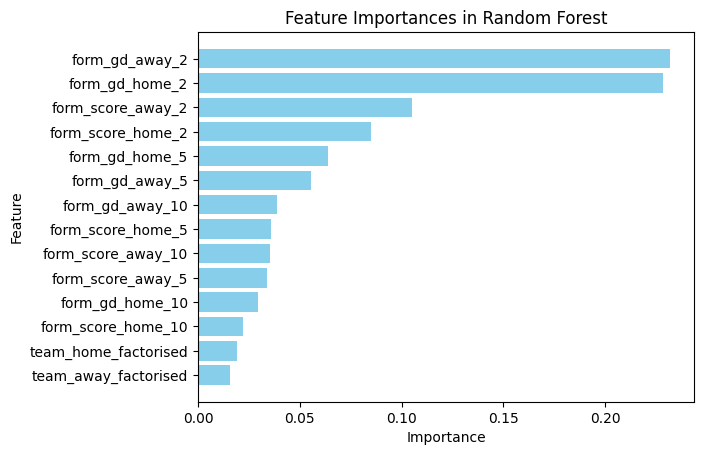

In [16]:
df_best_params = rf_results.sort_values('accuracy', ascending=False).iloc[0]

print(f"randomForestClassifier best parameters{df_best_params}")

feature_names = X_train.columns
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
#plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

<strong> XG Boost game prediction </strong>

In [17]:
xgb_model = XGBClassifier(random_state=42)

df = df[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',
        'result_num']]

X_train = df_train[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',]]

X_test = df_test[['form_score_home_10','form_score_away_10',
        'form_score_home_5','form_score_away_5',
        'form_score_home_2','form_score_away_2',
        'team_home_factorised','team_away_factorised',
        'form_gd_away_10','form_gd_home_10',
        'form_gd_away_5','form_gd_home_5',
        'form_gd_away_2','form_gd_home_2',]]

label_encoder = LabelEncoder()

Y_train,Y_test = label_encoder.fit_transform(df_train[['result_num']]),label_encoder.fit_transform(df_test[['result_num']])

Y_train,Y_test = Y_train.squeeze(),Y_test.squeeze()

param_grid = {
    'n_estimators': [200, 250, 300],      
    'max_depth': [15, 30, 45],       
    'learning_rate': [0.01, 0.1, 0.2],        
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}



xgb_results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree', 'accuracy', 'f1', 'roc_auc'])

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    
    xgb_model.set_params(**params)
    
    xgb_model.fit(X_train, Y_train)
    
    Y_pred = xgb_model.predict(X_test)
    Y_proba = xgb_model.predict_proba(X_test)
    
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    roc_auc = roc_auc_score(Y_test, Y_proba, multi_class='ovr')
    
    xgb_results = pd.concat([xgb_results, pd.DataFrame([{
        'n_estimators': params['n_estimators'],
        'max_depth': params['max_depth'],
        'learning_rate': params['learning_rate'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc
    }])], ignore_index=True)

C:\Users\zicza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zicza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}


C:\Users\zicza\AppData\Local\Temp\ipykernel_19644\2135086723.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  xgb_results = pd.concat([xgb_results, pd.DataFrame([{


Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.9}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 200, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 250, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 250, 'subsample': 0.9}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 250, 'subsample': 1.0}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'subsample': 0.8}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'subsample': 0.9}
Testing parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'subsample': 1.0}


XGBoost best parameters n_estimators              200
max_depth                  15
min_samples_split           2
min_samples_leaf            1
max_features             sqrt
accuracy             0.559322
f1                   0.518794
roc_auc              0.751326
Name: 0, dtype: object


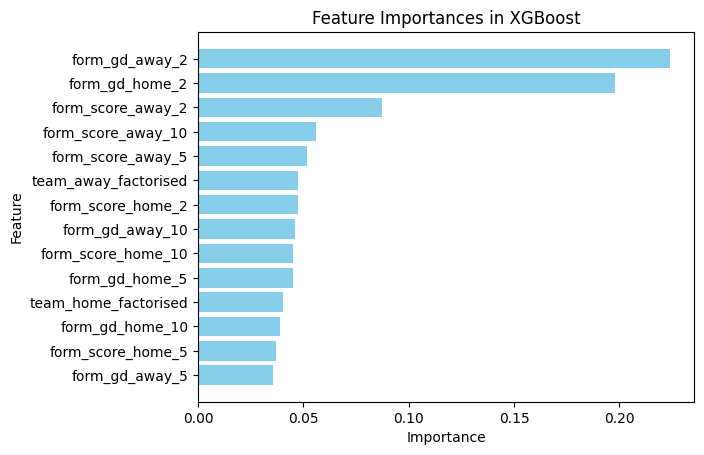

In [18]:
xgb_best_params = xgb_results.sort_values('accuracy', ascending=False).iloc[0]
print(f"XGBoost best parameters {df_best_params}")

feature_names = X_train.columns
importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
xg_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.barh(xg_importance_df['Feature'], xg_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in XGBoost')
plt.gca().invert_yaxis()
plt.show()

<strong>KNN Model classification </strong>

In [25]:
scaler = StandardScaler()

imputer = SimpleImputer(strategy='mean')

X_train =scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

neighbors = [8, 9, 10, 11, 12, 13]

knn_model_results = pd.DataFrame(columns=['n_neighbors', 'accuracy', 'f1', 'roc_auc'])

for n in neighbors:
    print(f"Testing n_neighbors: {n}")
    knn_model = KNeighborsClassifier(n_neighbors=n)

    knn_model.fit(X_train, Y_train)

    Y_pred = knn_model.predict(X_test)
    Y_proba = knn_model.predict_proba(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    roc_auc = roc_auc_score(Y_test, Y_proba, multi_class='ovr')

    knn_model_results = pd.concat([knn_model_results, pd.DataFrame([{
        'n_neighbors': n,
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc
    }])], ignore_index=True)

knn_best_params = knn_model_results.sort_values('accuracy', ascending=False).iloc[0]

Testing n_neighbors: 8
Testing n_neighbors: 9
Testing n_neighbors: 10
Testing n_neighbors: 11


C:\Users\zicza\AppData\Local\Temp\ipykernel_19644\2443554606.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  knn_model_results = pd.concat([knn_model_results, pd.DataFrame([{


Testing n_neighbors: 12
Testing n_neighbors: 13


<strong> Model Comparison rf vs xgb

In [ ]:

merged_df = pd.merge(
    rf_importance_df,
    xg_importance_df,
    on="Feature",
    how="outer",
    suffixes=('_rf', '_xg')
).fillna(0)  # Fill NaN with 0 for missing features

# Sort features by their total importance across models
merged_df['Total_Importance'] = merged_df['Importance_rf'] + merged_df['Importance_xg']
merged_df = merged_df.sort_values(by='Total_Importance', ascending=False)

# Plot side-by-side bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.4
y_positions = range(len(merged_df))

# Plot Random Forest importances
plt.barh(
    [y - bar_width / 2 for y in y_positions],
    merged_df['Importance_rf'],
    height=bar_width,
    color='skyblue',
    label='Random Forest'
)

# Plot XGBoost importances
plt.barh(
    [y + bar_width / 2 for y in y_positions],
    merged_df['Importance_xg'],
    height=bar_width,
    color='orange',
    alpha=0.7,
    label='XGBoost'
)

# Formatting the chart
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest and XGBoost')
plt.yticks(y_positions, merged_df['Feature'])
plt.legend()
plt.gca().invert_yaxis()  # Display highest total importance at the top
plt.tight_layout()
plt.show()
